# Feature Importance Methods for Scientific Inference

In these exercises you will:

1. *(Lecture)* Interpret the pre-computed PFI plot and discuss why it can mislead
2. Implement **Permutation Feature Importance (PFI)** yourself and visualise the out-of-distribution problem
3. Compute **Conditional Feature Importance (CFI)** using the `fippy` package
4. Compute **Leave-One-Covariate-Out (LOCO)** importance and interpret it in terms of explained variance
5. Compute **Global Mean Absolute SHAP** values using KernelSHAP

---

## Setup

Run all cells in this section before starting the exercises.

In [12]:
!pip install git+https://github.com/gcskoenig/fippy.git -q
!pip install shap -q

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Per-observation squared error required by fippy for confidence interval computation
def square_error(y_true, y_pred):
    return (np.array(y_true) - np.array(y_pred)) ** 2

plt.rcParams.update({
    'font.size':        14,
    'axes.titlesize':   16,
    'axes.labelsize':   14,
    'xtick.labelsize':  13,
    'ytick.labelsize':  13,
})

### Data

We generate a dataset with 5 features and a continuous target variable $Y$.
**The data-generating process is hidden for now.**

In [14]:
def generate_data(n=1500, seed=83):
    rng = np.random.RandomState(seed)
    x1 = rng.normal(0, 1, n)
    x2 = 0.999 * x1 + np.sqrt(1 - 0.999**2) * rng.normal(0, 1, n)
    x3 = rng.normal(0, 1, n)
    x4 = 0.999 * x3 + np.sqrt(1 - 0.999**2) * rng.normal(0, 1, n)
    y  = 5 * x1 + rng.normal(0, 1, n)
    x5 = rng.normal(0, 1, n)
    X  = np.column_stack([x1, x2, x3, x4, x5])
    return X, y

X, y = generate_data()
feature_names = ["X1", "X2", "X3", "X4", "X5"]
print(f"Dataset: {X.shape}, features: {feature_names}")

Dataset: (1500, 5), features: ['X1', 'X2', 'X3', 'X4', 'X5']


### Model

We train an OLS linear regression on 1000 training observations and evaluate on 500 held-out test observations.

In [15]:
n_train = 1000
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

model = LinearRegression().fit(X_train, y_train)
r2  = model.score(X_test, y_test)
print(f"Test R\u00b2: {r2:.3f}")
print(f"Coefficients: {np.round(model.coef_, 2)}")

Test R²: 0.963
Coefficients: [ 3.11  1.88 -2.11  2.17  0.02]


### fippy setup

We use the [`fippy`](https://github.com/gcskoenig/fippy) package for Exercises 3 and 4.
The **Gaussian sampler** estimates the conditional distribution $P(X_j \mid X_{-j})$ in closed form
using the multivariate normal assumption.

In [16]:
from fippy.explainers import Explainer
from fippy.samplers import GaussianSampler

# fippy requires pandas DataFrames
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df  = pd.DataFrame(X_test,  columns=feature_names)
y_train_s  = pd.Series(y_train, name='y')
y_test_s   = pd.Series(y_test,  name='y')

sampler   = GaussianSampler(X_train_df)
explainer = Explainer(model.predict, X_train_df,
                      loss=square_error, sampler=sampler)

---

# Exercise 2: Implement PFI and Understand Why It Can Mislead

Now we reveal the true data-generating process:

$$X_1 \sim \mathcal{N}(0,1), \quad X_3 \sim \mathcal{N}(0,1), \quad X_5 \sim \mathcal{N}(0,1) \quad \text{(mutually independent)}$$
$$X_2 = 0.999\,X_1 + \varepsilon_2, \qquad X_4 = 0.999\,X_3 + \varepsilon_4$$
$$Y = 5\,X_1 + \varepsilon_Y \qquad \Rightarrow \text{only } X_1 \text{ causes } Y$$

The fitted model is $\hat{f}(X) = 3.11\,X_1 + 1.88\,X_2 - 2.11\,X_3 + 2.17\,X_4 + 0.02\,X_5$.

**Tasks**

1. Complete `my_pfi` below — the only missing piece is the permutation of one column.
2. Create scatterplots of $(X_3, X_4)$ before and after permuting $X_3$.
3. Explain why PFI assigns high importance to $X_3$ and $X_4$ even though they are independent of $Y$.

PFI(X1): 0.0000
PFI(X2): 0.0000
PFI(X3): 0.0000
PFI(X4): 0.0000
PFI(X5): 0.0000


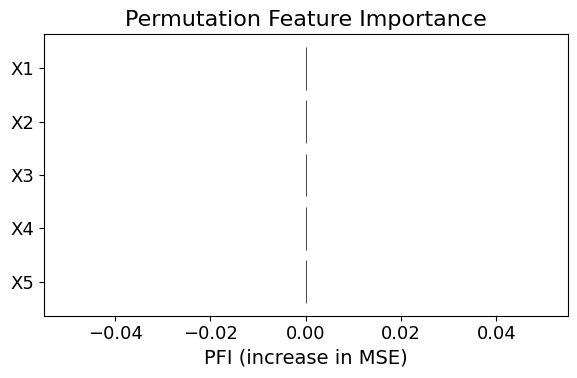

In [ ]:
def my_pfi(model, X, y, feature_idx, n_repeats=50, seed=42):
    """
    Permutation Feature Importance for a single feature.

    PFI_j = mean_r [ L(y, f(X_perm_r)) ] - L(y, f(X))

    where X_perm_r is X with column feature_idx randomly permuted.
    Use the mean_squared_error as loss and repeat the computation 50 times.
    """
    rng = np.random.RandomState(seed)
    baseline_mse = None # TODO your code here

    perturbed_mses = []
    for _ in range(n_repeats):
        X_perm = X.copy()
        # ── TODO YOUR CODE HERE ──────────────────────────────────────────
        # Permute column feature_idx of X_perm using rng.permutation()


    return np.mean(perturbed_mses) - baseline_mse


# Compute and plot PFI for all features
pfi_scores = [my_pfi(model, X_test, y_test, j) for j in range(len(feature_names))]
for name, score in zip(feature_names, pfi_scores):
    print(f"PFI({name}): {score:.4f}")

plt.figure(figsize=(6, 4))
plt.barh(feature_names[::-1], pfi_scores[::-1], color='grey', edgecolor='black', linewidth=0.5)
plt.xlabel("PFI (increase in MSE)")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()

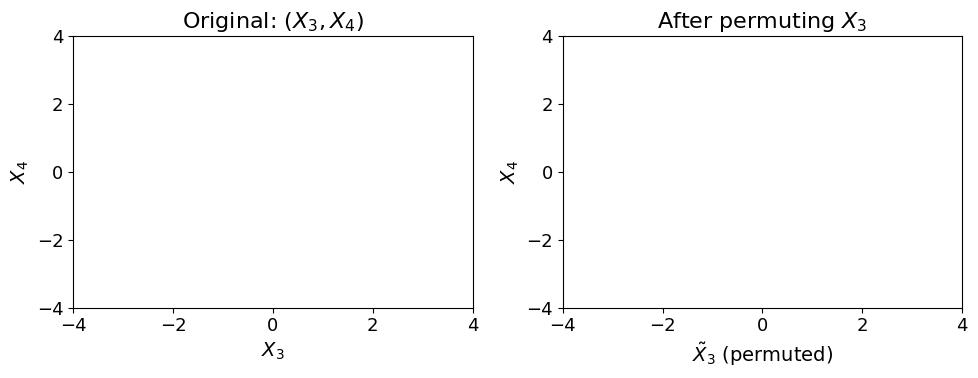

In [18]:
# Scatterplot: X3 vs X4 before and after permuting X3
rng = np.random.RandomState(42)
X_perm = X_test.copy()
# ── YOUR CODE HERE: permute column 2 (X3) of X_perm ────────────────────────


# ────────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ── YOUR CODE HERE: scatter X_test[:,2] vs X_test[:,3] on axes[0] ───────────



# ────────────────────────────────────────────────────────────────────────────
axes[0].set(xlabel="$X_3$", ylabel="$X_4$", title="Original: $(X_3, X_4)$",
            xlim=(-4,4), ylim=(-4,4))

# ── YOUR CODE HERE: scatter X_perm[:,2] vs X_perm[:,3] on axes[1] ───────────



# ────────────────────────────────────────────────────────────────────────────
axes[1].set(xlabel=r"$\tilde{X}_3$ (permuted)", ylabel="$X_4$",
            title="After permuting $X_3$", xlim=(-4,4), ylim=(-4,4))

plt.tight_layout()
plt.show()

**Your explanation:**

- What do you notice in the scatterplots?
  - *Your answer here*

- Why does PFI assign high importance to $X_3$ and $X_4$?
  - *Your answer here*

---

# Exercise 3: Conditional Feature Importance (CFI)

Instead of breaking all dependencies (permutation sampler), CFI resamples $X_j$ from
$P(X_j \mid X_{-j})$, preserving the feature correlations.

$$\text{CFI}_j = \mathbb{E}[L(Y, \hat{f}(\tilde{X}_j, X_{-j}))] - \mathbb{E}[L(Y, \hat{f}(X))], \quad \tilde{X}_j \sim P(X_j \mid X_{-j})$$

We use `fippy`'s `GaussianSampler` to estimate the conditional distribution in closed form.

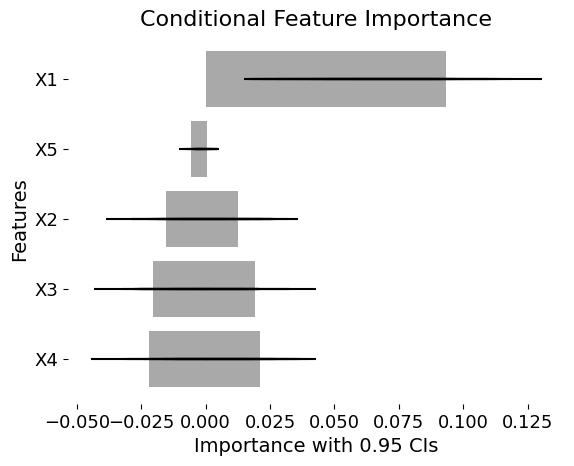


CFI scores:
  X1: 0.0676 ± 0.0137
  X2: 0.0012 ± 0.0080
  X3: -0.0006 ± 0.0110
  X4: 0.0036 ± 0.0123
  X5: -0.0015 ± 0.0021


In [19]:
# Conditional Feature Importance via fippy
ex_cfi = explainer.cfi(X_test_df, y_test_s, nr_runs=10)
ex_cfi.hbarplot()
plt.show()

scores_agg = ex_cfi.scores.groupby('sample').mean()
means = scores_agg.mean()
stds  = scores_agg.std()
print("\nCFI scores:")
for feat in feature_names:
    print(f"  {feat}: {means[feat]:.4f} ± {stds[feat]:.4f}")

**Interpretation:**

- How do CFI scores differ from PFI? Why?
  - *Your answer here*

- Which features receive non-zero CFI, and why?
  - *Your answer here*

---

# Exercise 4: Leave-One-Covariate-Out (LOCO)

LOCO measures how much the model's **explained variance** drops when a feature is removed entirely.

Using the conditional SAGE value function $v(S)$ — which quantifies the explained variance
when only features $S$ are available:

$$v(S) = \mathbb{E}[(Y - \mathbb{E}[f(X)])^2] - \mathbb{E}[(Y - \mathbb{E}[f(X)\mid X_S])^2]$$

LOCO is:
$$\text{LOCO}_j = v(\{1,\ldots,p\}) - v(\{1,\ldots,p\} \setminus \{j\})$$

We compute all leave-one-out values at once using `fippy`'s `csagevfs` method with `C='remainder'`.

v(N) train = 27.5201,  v(N) test = 30.8741

LOCO (train):
  X1: 0.0217 ± 0.0032  (0.1%)
  X2: 0.0081 ± 0.0023  (0.0%)
  X3: 0.0092 ± 0.0018  (0.0%)
  X4: 0.0115 ± 0.0022  (0.0%)
  X5: 0.0003 ± 0.0004  (0.0%)

LOCO (test):
  X1: 0.0458 ± 0.0035  (0.1%)
  X2: -0.0076 ± 0.0027  (-0.0%)
  X3: -0.0083 ± 0.0018  (-0.0%)
  X4: -0.0121 ± 0.0026  (-0.0%)
  X5: -0.0008 ± 0.0006  (-0.0%)



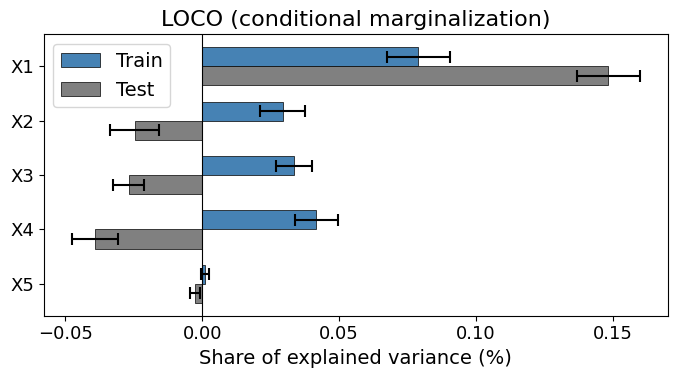

In [20]:
N = feature_names  # full coalition

# v(N) on training and test data
ex_vN_train = explainer.csagevf(S=list(N), X_eval=X_train_df, y_eval=y_train_s)
v_N_train = float(ex_vN_train.scores.groupby('sample').mean().mean().iloc[0])
ex_vN_test  = explainer.csagevf(S=list(N), X_eval=X_test_df,  y_eval=y_test_s)
v_N_test  = float(ex_vN_test.scores.groupby('sample').mean().mean().iloc[0])
print(f"v(N) train = {v_N_train:.4f},  v(N) test = {v_N_test:.4f}\n")

# LOCO = v(N) - v(N\{j}) for every j; nr_runs repetitions to capture variability
ex_loco_train = explainer.csagevfs(X_train_df, y_train_s, C='remainder', nr_runs=10)
ex_loco_test  = explainer.csagevfs(X_test_df,  y_test_s,  C='remainder', nr_runs=10)

def loco_stats(ex_loco, v_N, label):
    agg   = ex_loco.scores.groupby('sample').mean()
    means, stds = agg.mean(), agg.std()
    print(f"LOCO ({label}):")
    for feat in feature_names:
        m, s = means[feat], stds[feat]
        print(f"  {feat}: {m:.4f} ± {s:.4f}  ({100 * m / v_N:.1f}%)")
    print()
    return means, stds

means_train, stds_train = loco_stats(ex_loco_train, v_N_train, "train")
means_test,  stds_test  = loco_stats(ex_loco_test,  v_N_test,  "test")

# Grouped horizontal bar plot (% of each split's explained variance)
pct_tr = [100 * means_train[f] / v_N_train for f in N]
pct_te = [100 * means_test[f]  / v_N_test  for f in N]
err_tr = [100 * stds_train[f]  / v_N_train for f in N]
err_te = [100 * stds_test[f]   / v_N_test  for f in N]

y_pos  = np.arange(len(N))
height = 0.35
fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(y_pos + height/2, pct_tr[::-1], height, xerr=err_tr[::-1],
        label='Train', color='steelblue', edgecolor='black', linewidth=0.5,
        capsize=4, error_kw={'elinewidth': 1.5, 'capthick': 1.5})
ax.barh(y_pos - height/2, pct_te[::-1], height, xerr=err_te[::-1],
        label='Test',  color='grey',      edgecolor='black', linewidth=0.5,
        capsize=4, error_kw={'elinewidth': 1.5, 'capthick': 1.5})
ax.set_yticks(y_pos)
ax.set_yticklabels(N[::-1])
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel("Share of explained variance (%)")
ax.set_title("LOCO (conditional marginalization)")
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation:**

- Which features have non-zero LOCO on training vs. test data, and how do the scores differ?
  - *Your answer here*

- Some features show a positive LOCO on training data but a negative LOCO on test data. What does a negative LOCO mean, and why might this happen?
  - *Your answer here*

- How do LOCO scores differ from CFI, and what additional information do they provide?
  - *Your answer here*

---

# Exercise 5: Global Feature Importance with KernelSHAP

KernelSHAP estimates Shapley values — a game-theoretic attribution of each feature's
contribution to the model output — by fitting a weighted linear model over coalition samples.
The global importance of feature $j$ is the mean absolute SHAP value across test observations:

$$\text{MeanSHAP}_j = \frac{1}{n}\sum_{i=1}^{n} |\phi_j^{(i)}|$$

**Tasks**

1. Run the cell below and compare the KernelSHAP ranking with PFI, CFI, and LOCO.
2. How does KernelSHAP handle the correlated features $X_3$ and $X_4$?

100%|██████████| 500/500 [00:00<00:00, 1679.62it/s]


Mean |SHAP| values:
  X1: train=2.5343  test=2.5705
  X2: train=1.5369  test=1.5573
  X3: train=1.6766  test=1.5555
  X4: train=1.7315  test=1.6069
  X5: train=0.0138  test=0.0145


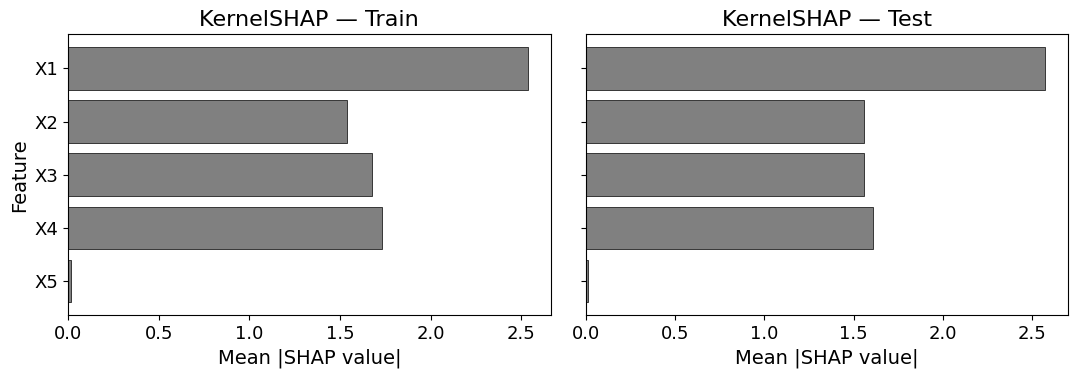

In [21]:
import shap

# Use 100 random background samples for efficiency
background = shap.sample(X_train_df, 100, random_state=42)
shap_explainer = shap.KernelExplainer(model.predict, background)

shap_values_train = shap_explainer.shap_values(X_train_df)
shap_values_test  = shap_explainer.shap_values(X_test_df)

mean_abs_train = np.abs(shap_values_train).mean(axis=0)
mean_abs_test  = np.abs(shap_values_test).mean(axis=0)

print("Mean |SHAP| values:")
for name, tr, te in zip(feature_names, mean_abs_train, mean_abs_test):
    print(f"  {name}: train={tr:.4f}  test={te:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
for ax, vals, title in zip(axes,
                            [mean_abs_train, mean_abs_test],
                            ["KernelSHAP — Train", "KernelSHAP — Test"]):
    ax.barh(feature_names[::-1], vals[::-1], color='grey', edgecolor='black', linewidth=0.5)
    ax.set_xlabel("Mean |SHAP value|")
    ax.set_title(title)
axes[0].set_ylabel("Feature")
plt.tight_layout()
plt.show()

**Interpretation:**

- How does the KernelSHAP ranking compare to PFI, CFI, and LOCO?
  - *Your answer here*

- How does KernelSHAP distribute importance between the correlated pair $(X_3, X_4)$?
  - *Your answer here*